In [1]:
import numpy as np
import ctypes
from numpy.ctypeslib import ndpointer

# Chargement de la bibliothèque
lib = ctypes.CDLL('./libdft.so')

# Définition de la structure pour cuDoubleComplex
class cuDoubleComplex(ctypes.Structure):
    _fields_ = [('x', ctypes.c_double),
                ('y', ctypes.c_double)]

# Configuration des types pour la fonction
lib.compute_dft.argtypes = [
    ctypes.POINTER(cuDoubleComplex),
    ctypes.POINTER(cuDoubleComplex),
    ctypes.c_int
]
lib.compute_dft.restype = None

def dft(signal):
    N = len(signal)
    
    # Conversion du signal en tableau de cuDoubleComplex
    input_array = (cuDoubleComplex * N)()
    output_array = (cuDoubleComplex * N)()
    
    # Remplissage du tableau d'entrée
    for i in range(N):
        input_array[i].x = signal[i].real
        input_array[i].y = signal[i].imag
    
    # Appel de la fonction CUDA
    lib.compute_dft(input_array, output_array, N)
    
    # Conversion du résultat en numpy array
    result = np.zeros(N, dtype=np.complex128)
    for i in range(N):
        result[i] = output_array[i].x + 1j * output_array[i].y
    
    return result

In [11]:
t = np.linspace(0, 1, 1024)
signals = [np.sin(2 * np.pi * 10 * t), np.sin(2 * np.pi * 20 * t)]
signal = np.sum(signals, axis=0)

spectrum = dft(signal)

In [12]:
import matplotlib.pyplot as plt

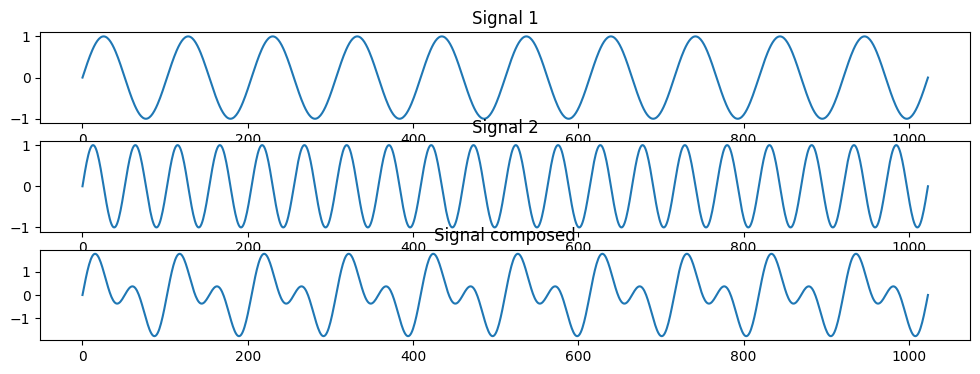

In [14]:
plt.figure(figsize=(12, 4))
for i, composed_signal in enumerate(signals):
    plt.subplot(len(signals)+1, 1, i + 1)
    plt.plot(composed_signal)
    plt.title(f'Signal {i+1}')
plt.subplot(len(signals)+1, 1, len(signals)+1)
plt.plot(signal)
plt.title(f'Signal composed')
plt.show()

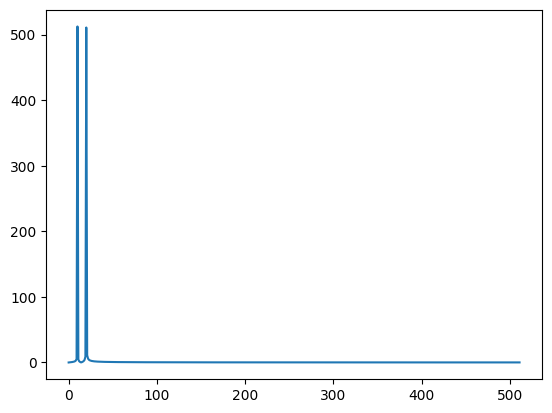

In [21]:
plt.plot(np.abs(spectrum[:len(spectrum)//2]))
plt.show()

In [24]:
# Paramètres du signal
N = 1024  # Nombre de points
fs = 1.0/(t[1] - t[0])  # Fréquence d'échantillonnage

# Trouver les pics significatifs
threshold = np.max(np.abs(spectrum)) * 0.1
peak_indices = np.where(np.abs(spectrum) > threshold)[0]
frequencies = peak_indices * (fs/N)  # Correction de la formule de fréquence

print("Pics de fréquence détectés :")
for idx, freq in zip(peak_indices, frequencies):
    if freq <= fs/2:  # On ne garde que les fréquences jusqu'à fs/2 (théorème de Nyquist)
        print(f"Fréquence: {freq:.1f} Hz, Amplitude: {np.abs(spectrum[idx]):.2f}")

Pics de fréquence détectés :
Fréquence: 10.0 Hz, Amplitude: 512.33
Fréquence: 20.0 Hz, Amplitude: 510.76
